# Mounting drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
#drive.mount('/content/gdrive/')

Mounted at /content/gdrive


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf

# Classifing the images into class Label list

In [ ]:
import os
import csv
import shutil

# Path to the folder
folder_path = "/content/gdrive/MyDrive/malaria1/Label"
source_path= "/content/gdrive/MyDrive/malaria1/images"
dest_folder1="/content/gdrive/MyDrive/img/uninfected"
dest_folder2="/content/gdrive/MyDrive/img/infected"

# Function to read values from the first column of text files
def read_first_column(file_path):
    with open(file_path, 'r') as file:
        first_column_values=[]
        reader = csv.reader(file, delimiter=' ')  # Assuming tab-delimited
        for row in reader:
            cleaned_list = [item.strip() for item in row if isinstance(item, str) and item.strip()]
            first_column_values.append(cleaned_list[0])
    # with open(file_path, 'r') as file:
    #     reader = csv.reader(file, delimiter=' ')  # Assuming tab-delimited
    #     first_column_values = [row[2] for row in reader]
    return first_column_values

# Function to categorize files
def categorize_files(folder_path):
    uninfected = []
    infected = {}
    # List all files in the folder
    files = os.listdir(folder_path)
    # Iterate through each file
    for file_name in files:
        if file_name.endswith('.txt'):  # Assuming all files are text files
            file_path = os.path.join(folder_path, file_name)
            first_column_values = read_first_column(file_path)
            if all(value == "0" for value in first_column_values):
                uninfected.append(file_name)
            else:
                count = sum(1 for value in first_column_values if value != "0")
                infected[file_name] = count


    return uninfected, infected

# Call the function to categorize files
uninfected_files, infected_files = categorize_files(folder_path)


# Counting Number of cells infected

In [ ]:
c=0
infected1=[]
for file_name, count in infected_files.items():
  if(count>3):
    c=c+1
    infected1.append(file_name)
    # print(f"{file_name}: {count}")
print(c)



# Classifing into directories

In [ ]:
import os
import shutil

def separate_images(txt_list1, txt_list2, source_folder, dest_folder1, dest_folder2):
    # Create destination folders if they don't exist
    os.makedirs(dest_folder1, exist_ok=True)
    os.makedirs(dest_folder2, exist_ok=True)

    # Iterate over each text file in the first list
    for txt_file in txt_list1:
        # Construct the corresponding image file name
        img_file = os.path.splitext(txt_file)[0] + ".png"
        img_path = os.path.join(source_folder, img_file)
        # Check if the image file exists
        if os.path.exists(img_path):
            shutil.copy(img_path, dest_folder1)

    # Iterate over each text file in the second list
    for txt_file in txt_list2:
        # Construct the corresponding image file name
        img_file = os.path.splitext(txt_file)[0] + ".png"
        img_path = os.path.join(source_folder, img_file)
        # Check if the image file exists
        if os.path.exists(img_path):
            shutil.copy(img_path, dest_folder2)

# Example usage:


source_path= "/content/gdrive/MyDrive/malaria1/images"
dest_folder1="/content/gdrive/MyDrive/img3/uninfected"
dest_folder2="/content/gdrive/MyDrive/img3/infected"


separate_images(uninfected_files, infected1, source_path, dest_folder1, dest_folder2)


# Train Data Splitting

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the source and destination directories
source_dir = '/content/gdrive/MyDrive/img3/'
train_dir = '/content/gdrive/MyDrive/dataset2/train/'
test_dir = '/content/gdrive/MyDrive/dataset2/test/'

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subdirectories for each class in the train and test directories
class_names = os.listdir(source_dir)
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Function to split and save images
def split_and_save_images(source_dir, train_dir, test_dir, class_names, test_size=0.2, seed=111):
    for class_name in class_names:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)

        train_images, test_images = train_test_split(images, test_size=test_size, random_state=seed)

        # Copy images to respective directories
        for image in train_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))

        for image in test_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

# Split and save the images
split_and_save_images(source_dir, train_dir, test_dir, class_names)

print("Images split and saved successfully.")


Images split and saved successfully.


# Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score  # Import accuracy_score here

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Simple rescaling for validation/test set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Directory paths
train_dir = '/content/gdrive/MyDrive/dataset2/train'
test_dir = '/content/gdrive/MyDrive/dataset2/test'

# Training and test generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Model architecture (example)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

# Save the model
model.save('/content/malaria_class_augmented.h5')
# Evaluate on test data
predictions = model.predict(test_generator, steps=np.ceil(test_generator.n / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')


Found 273 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
Epoch 1/30
5/5 [==============================] - 75s 13s/step - loss: 3.2457 - accuracy: 0.5238 - val_loss: 1.0638 - val_accuracy: 0.4714
Epoch 2/30
5/5 [==============================] - 69s 16s/step - loss: 0.8086 - accuracy: 0.4908 - val_loss: 0.7922 - val_accuracy: 0.4714
Epoch 3/30
5/5 [==============================] - 66s 12s/step - loss: 0.7254 - accuracy: 0.4799 - val_loss: 0.6912 - val_accuracy: 0.4714
Epoch 4/30
5/5 [==============================] - 68s 13s/step - loss: 0.6792 - accuracy: 0.5495 - val_loss: 0.6722 - val_accuracy: 0.7286
Epoch 5/30
5/5 [==============================] - 65s 15s/step - loss: 0.7039 - accuracy: 0.4762 - val_loss: 0.6892 - val_accuracy: 0.5286
Epoch 6/30
5/5 [==============================] - 72s 17s/step - loss: 0.6907 - accuracy: 0.5311 - val_loss: 0.6829 - val_accuracy: 0.5286
Epoch 7/30
5/5 [==============================] - 66s 12s/step - loss: 0.6837 - accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 9s 2s/step
              precision    recall  f1-score   support

    infected       0.86      0.81      0.83        37
  uninfected       0.80      0.85      0.82        33

    accuracy                           0.83        70
   macro avg       0.83      0.83      0.83        70
weighted avg       0.83      0.83      0.83        70

Accuracy: 82.86%


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

# Plotting

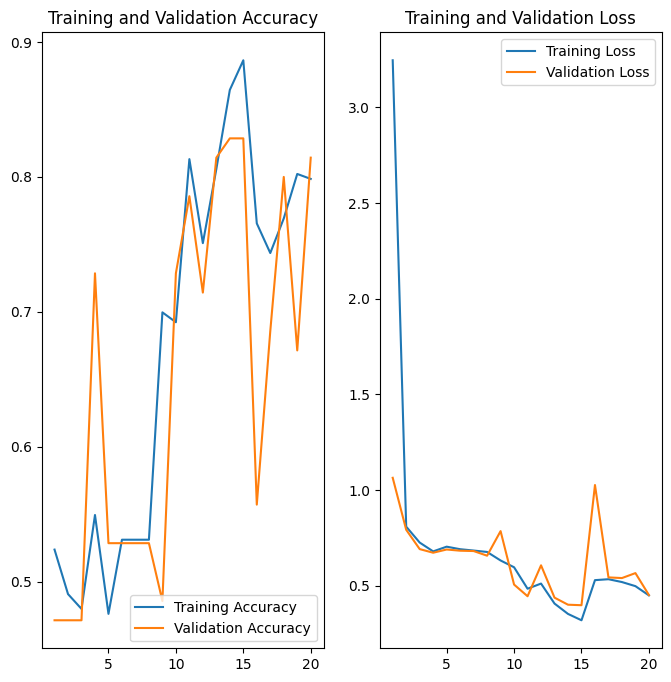

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import os
print("Current directory:", os.getcwd())
print("Files in current directory:", os.listdir())


Current directory: /content
Files in current directory: ['.config', 'gdrive', 'malaria_class_augmented.h5', 'sample_data']


In [ ]:
!pip install tensorflow

# Converting to tflite


In [ ]:
import tensorflow as tf

# Load the Keras model from .h5 file
model = tf.keras.models.load_model("malaria_class_augmented.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a .tflite file
with open("malaria_classification82.tflite", "wb") as f:
    f.write(tflite_model)


# Label prediction on test data

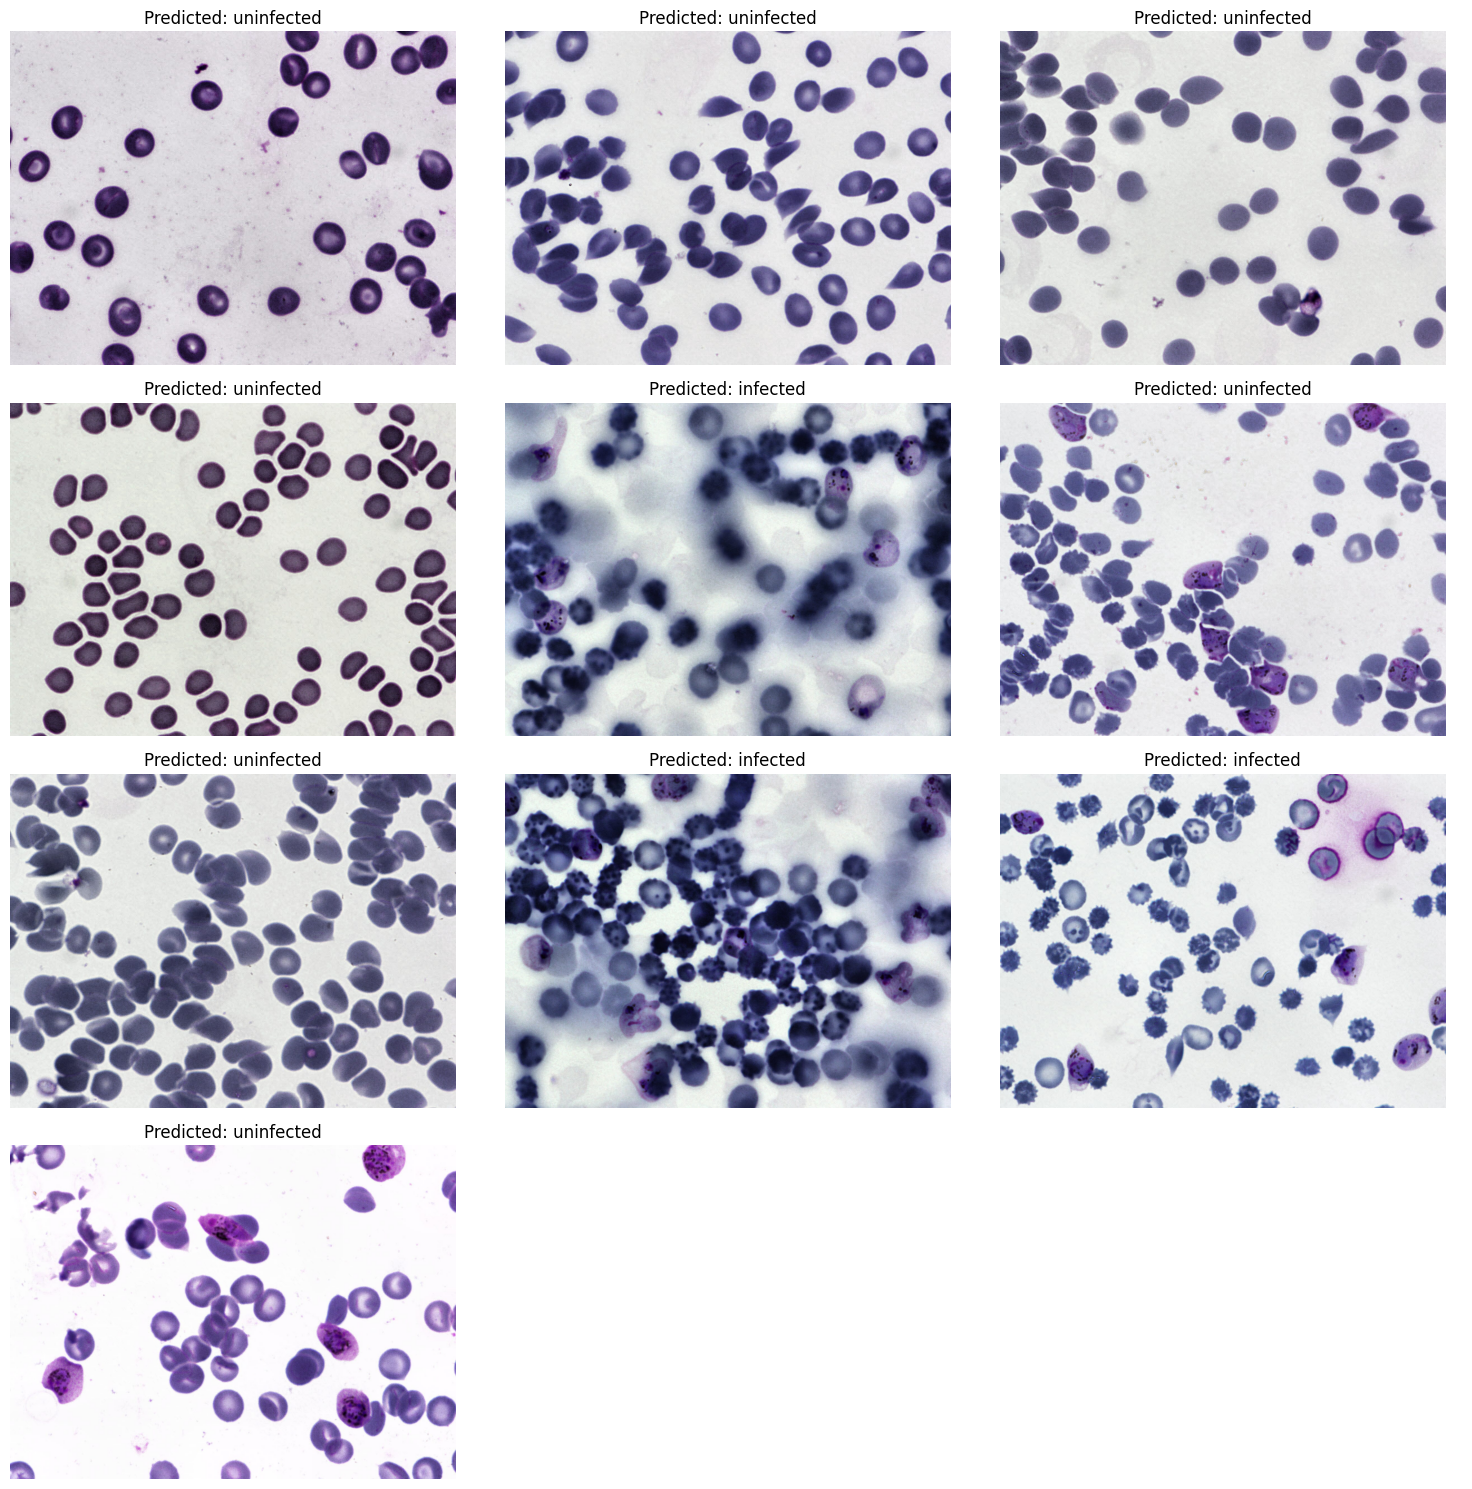

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/malaria_classification82.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get input shape
input_shape = input_details[0]['shape']
IMG_HEIGHT, IMG_WIDTH = input_shape[1], input_shape[2]

def preprocess_image(image_path):
    # Load image
    img = Image.open(image_path).convert('RGB')
    # Resize image
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    # Convert image to numpy array
    img = np.array(img).astype(np.float32)  # Ensure the data type is float32
    # Normalize the image to [0, 1]
    img = img / 255.0
    # Add batch dimension
    img = np.expand_dims(img, axis=0)
    return img

def predict_image(image_path):
    # Preprocess the image
    input_data = preprocess_image(image_path)

    # Set the tensor to point to the input data to be inferred
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run the inference
    interpreter.invoke()

    # Get the results
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Define class labels
class_labels = ['infected', 'uninfected']

def predict_images_in_folder(folder_path):
    image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)
                   if filename.endswith(".jpg") or filename.endswith(".png")]

    # Define the number of images per row
    images_per_row = 3

    # Create subplots
    fig, axes = plt.subplots(nrows=len(image_paths) // images_per_row + 1,
                             ncols=images_per_row, figsize=(15, 15))

    for idx, image_path in enumerate(image_paths):
        predictions = predict_image(image_path)
        predicted_class = class_labels[np.argmax(predictions)]

        # Load the original image for visualization
        original_img = Image.open(image_path).convert('RGB')

        # Get the appropriate subplot
        ax = axes[idx // images_per_row, idx % images_per_row]

        # Display the image with the predicted label
        ax.imshow(original_img)
        ax.set_title(f"Predicted: {predicted_class}")
        ax.axis('off')  # Hide axes

    # Hide any remaining empty subplots
    for j in range(len(image_paths), len(axes.flat)):
        axes.flat[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
predict_images_in_folder('/content/gdrive/MyDrive/td')
